In [1]:
import numpy as np
import pandas as pd
import random as rand_
import matplotlib.pyplot as plt

from math import pi, cos, exp, floor, atan
from cmath import sqrt
from scipy.signal import StateSpace, impulse2, lsim2
from scipy.optimize import least_squares
from jupyterthemes import jtplot

jtplot.style()

In [2]:
class MOLIwhiteBox:
    def __init__(self, method):
        self.C = np.array([[0., 0., 0., 1.]])
        if method is None:
            method = 'trivial'
        self.filter = method
        self.structure() #defines the model structure
        self.describe() #print a model definition
        
    def structure(self):
        if self.filter == 'trivial':
            zeta = 0.
            omega = pi/12.0
            _p1 = -zeta*omega + omega*sqrt(zeta**2-1)
            _p2 = -zeta*omega - omega*sqrt(zeta**2-1)
            syscpoly = np.poly((-1.0*0.0353,_p1,_p2))
            sysc = np.concatenate((np.zeros([1]),np.flip(-syscpoly[1:])),0)
            
            A_ = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A_ = np.concatenate((A_,sysc.reshape([4,1])),1)
            
            alphacand = np.poly(np.linalg.eig(A_)[0])
            A0 = np.concatenate((np.zeros([1,3]),np.identity(3)),0)
            A0 = np.concatenate((A0,-np.flip(alphacand[1:]).reshape([4,1])),1)
            self.A = A0
            
    def describe(self):
        print('This is a MOLI white Box alertness model')
        
    def fit(self, timeSamp, y, windowDecision):   
        self.awakeRegression(timeSamp, y) #determine the parameters during the day
        self.parameters(timeSamp) #determine the bio/physical parameters
        self.sim_Back_Forward(timeSamp, y, windowDecision) #determine the homeostatic vicinities
        self.sleepRegression()
        
    def awakeRegression(self, timeSamp, y):
        A_, C_, I_ = np.transpose(self.A), np.transpose(self.C), np.identity(4) 
        sFilt = StateSpace(A_,C_,I_,np.zeros([4,1]))
        _B, regres, _y = np.zeros([4,y.size]), np.array([]), []
    
        for i in range(y.size):
            sigAl, _time = np.asarray(y[i]), np.asarray(timeSamp[i])
            
            time_sim = _time - _time[0] #initialize time at t[0] = 0 (hours)
            impT, impResp = impulse2(sFilt, 0, time_sim, N = 10000) #simulate B info
            outT, outResp, x2 = lsim2(sFilt, sigAl, time_sim) #simulate L info
            
            comp = np.zeros([impT.size,4*y.size])
            comp[:,4*i:4*(i+1)] = impResp
            aux = np.concatenate((outResp,comp),1)
            
            if i == 0: #initialize the regressor, or add info to the regressor
                regres = aux
                _y = np.asarray(y[i])
            else:
                regres = np.concatenate((regres,aux), 0)
                _y = np.concatenate((_y,np.asarray(y[i])), 0)
                
        theta = np.linalg.lstsq(regres, _y, rcond=None)[0] #solve the regression problem
        
        for i in range(y.size):
            init = 4*(i+1)
            final = 4*(i+1) + 4
            _B[:,i] = theta[init:final]
        self.L = theta[:4] #determine L 
        self.B = _B #determine several B
        
        
    def parameters(self, timeSamp):
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        self.w = (-Ao[2,3])**0.5
        self.tau = (self.w**2)/(-Ao[1,3])
        
        DC = np.zeros([timeSamp.size,1])
        ho = np.zeros([timeSamp.size,1])
        cphase = np.zeros([timeSamp.size,1])
        M = np.zeros([timeSamp.size,1])
        
        _X = np.array([[self.w**2, 0., 1.0/self.tau],
                       [0., 1.0/self.tau, 1.0],
                       [1.0, 1.0, 0.]])
        
        for i in range(timeSamp.size):
            DC[i] = self.B[0,i]*self.tau/(self.w**2)
            compensator = np.array([-DC[i]*self.w**2, -DC[i]/self.tau, -DC[i]])
            
            _B = self.B[1:,i].reshape(3,1) + compensator
            _Th = np.linalg.lstsq(_X, _B, rcond=None)[0]
            
            ho[i] = _Th[0]
            tan_cphase = _Th[2]/(-self.w)/_Th[1]
            
            if tan_cphase < 0:
                cph = atan(tan_cphase) - pi
            else:
                cph = atan(tan_cphase)
            cphase[i] = cph - self.w*(timeSamp[i][0] - 24*i)
            M[i] = _Th[1]/cos(cph)
            
        self.M = np.mean(M)
        self.DC = np.mean(DC)
        self.ho = ho
        self.cphase = np.mean(cphase)
    
    def sim_Back_Forward(self,timeChange,y,windowDecision):
        
        self.hNight = pd.DataFrame(columns = {'h_s','h_w','t_s','t_w'})
        Ao = self.A + np.matmul(self.L.reshape([4,1]),self.C)
        _final = 0.0
        
        for i in range(y.size):
            _init = 24.0*i
            dt = _init - _final
            _final = _init + windowDecision[i]
            if i != (y.size - 1):
                step = (_final - timeChange[i][0]) / 100.0
                time_samp = [step*k + timeChange[i][0] for k in range(101)]
                #print(time_samp[-1])
                sysF = StateSpace(Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                outT, outRes = impulse2(sysF, T = (time_samp - time_samp[0]))
                circadian = self.M*cos(self.w*time_samp[-1] + self.cphase)
                #print(circadian)
                self.hNight.loc[i,'h_s'] = outRes[-1] - circadian #- self.DC
                self.hNight.loc[i,'t_s'] = time_samp[-1]
                #plt.plot(time_samp,outRes)
                #plt.scatter(timeChange[i],y[i])
                
            if i != 0:
                step_n = (timeChange[i][0] - _init) / 100.0
                time_night = [step_n*k + _init for k in range(101)]
                sysB = StateSpace(-Ao, self.B[:,i].reshape([4,1]), self.C, np.zeros([1,1]))
                
                outT_n, outRes_n = impulse2(sysB, T = (time_night - time_night[0]))
                circadian = self.M*cos(self.w*time_night[0] + self.cphase)
                self.hNight.loc[i-1,'h_w'] = outRes_n[-1] - circadian #- self.DC
                self.hNight.loc[i-1,'t_w'] = time_night[0]
                #plt.plot(time_night,outRes_n)
    #plt.show()
    
    def cost_function(self,x,sTime,sHom,wHom):
        c = [x[0]*(1-exp(-sTime[k]/x[1])) + sHom[k]*exp(-sTime[k]/x[1]) - wHom[k] 
             for k in range(sTime.size)]
        return c
    
    def sleepRegression(self):
        sTime = np.asarray(self.hNight.loc[:,'t_w'].values - self.hNight.loc[:,'t_s'].values)
        #print(sTime.size)
        init__ = np.array([2.0, 8.0])
        aW, aS = self.hNight.loc[:,'h_w'].values, self.hNight.loc[:,'h_s'].values
        #print(aW, aS)
        res_ = least_squares(self.cost_function, init__, args = (sTime, aS, aW) )
        self.sPar = res_
        

In [5]:
class simAlert:
    def __init__(self,numDays):
        self.days = numDays
        self.time = pd.DataFrame()
        self.levAl = pd.DataFrame()
        self.levHom = pd.DataFrame()
        self.change = pd.DataFrame(columns = {'init','final'})
        self.omega = pi/12.0
        self.tau = 1/0.0353
        self.M = 2.52
        self.phi = -16.835*pi/12.0
        self.DC = 2.4
        self.y_ = 14.3
        self.tau_e = 1/0.381
        self.smpAl = pd.DataFrame(columns = {'time','levAl'} )
    
    def generate(self,windowDecision,resolution):
        initAl = 14.3
        self.resolution = resolution
        self.windows = windowDecision
        for i in range(self.days):
            unTime = [24*i + 24*j/self.resolution for j in range(resolution)]
            wTime = [j - 24*i for j in unTime if (j - 24*i) <= windowDecision[i]]
            sTime = [j - 24*i - windowDecision[i] for j in unTime 
                     if (j - 24*i) >= windowDecision[i]]
            
            circadian = [self.M*cos(self.omega*k + self.phi) for k in unTime]
            wHom = [(initAl - self.DC)*exp(-k/self.tau) + self.DC for k in wTime]
            sHom = [self.y_*(1-exp(-k/self.tau_e)) + wHom[-1]*exp(-k/self.tau_e) 
                    for k in sTime]
            Hom = np.concatenate((wHom,sHom))
            #print(Hom.shape)
            self.levHom.loc[:,i] = Hom[:resolution]
            self.levAl.loc[:,i] = circadian[:resolution] + Hom[:resolution]
            self.time.loc[:,i] = unTime[:resolution]
            initAl = Hom[-1]
    
    def randSample(self,ppH,seed):
        size_ = floor(max(self.windows)*ppH)
        time, levAl, day = [], [], []
        
        for i in range(self.days):
            step = floor(self.resolution/(24*ppH))
            final_ = floor(self.windows[i]*step*ppH)
            samples = range(0,final_,step)
            
            spH = floor(self.resolution/24.0)
            cruzeArr = [k - floor(spH/(2*ppH)) for k in range(0,floor(spH/ppH),1)]
            self.index = cruzeArr
            self.ind = samples
            cruzeInc = rand_.sample(cruzeArr, len(samples))
            if cruzeInc[0] < 0:
                cruzeInc[0] = 0
            if cruzeInc[-1] > 0:
                cruzeInc[-1] = 0
            samples_inc = np.asarray(cruzeInc) + samples

            time.append(self.time.loc[samples_inc,i].values)
            levAl.append(self.levAl.loc[samples_inc,i].values)
            
        self.smpAl.time = time
        self.smpAl.levAl = levAl           

In [6]:
alertData = simAlert(4) #number_days
alertData.generate([16,15.5,16,13], 100000) #window_decision, resolution
alertData.randSample(2,5) #points_per_hour (ppH), seed (random)

<IPython.core.display.Javascript object>


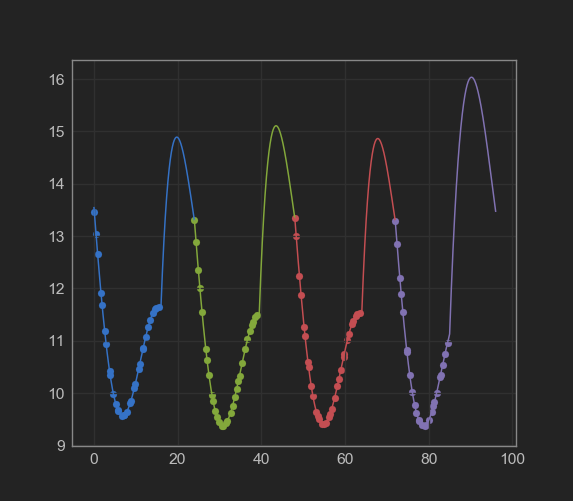

In [7]:
%matplotlib notebook
plt.plot(alertData.time,alertData.levAl)
for i in range(alertData.smpAl.time.size):
    plt.scatter(alertData.smpAl.time[i],alertData.smpAl.levAl[i])

In [8]:
modelMOLI = MOLIwhiteBox('trivial')

This is a MOLI white Box alertness model


In [9]:
setTime = alertData.smpAl.time
setAl = alertData.smpAl.levAl

In [10]:
k = np.array([])
for i in range(setTime.size):
    if i == 0:
        k = np.asarray(setTime[i])
    else:
        k = np.concatenate((k,np.asarray(setTime[i])),0)
#print(k)
test = np.array(k)
#np.unique(test, return_counts = True)
np.diff(test)

array([0.41304, 0.37152, 0.81096, 0.2604 , 0.61392, 0.34728, 0.8352 ,
       0.12072, 0.77952, 0.57792, 0.5316 , 0.03432, 0.9132 , 0.50736,
       0.08496, 0.5688 , 0.80976, 0.1728 , 0.81624, 0.21096, 0.82872,
       0.24888, 0.74304, 0.09888, 0.5736 , 0.63072, 0.486  , 0.618  ,
       0.4632 , 0.28704, 0.65496, 8.50248, 0.40392, 0.53664, 0.37536,
       0.50712, 0.91416, 0.29808, 0.43392, 0.74112, 0.24336, 0.51912,
       0.42912, 0.51072, 0.6876 , 0.30552, 0.69552, 0.29352, 0.74136,
       0.474  , 0.546  , 0.43416, 0.4476 , 0.2448 , 0.65928, 0.68952,
       0.55728, 0.54984, 0.44952, 0.2436 , 0.53688, 0.52896, 9.0024 ,
       0.3312 , 0.77832, 0.39336, 0.73056, 0.20256, 0.71088, 0.15624,
       0.60552, 0.42504, 0.8184 , 0.2964 , 0.33528, 0.69024, 0.49896,
       0.42576, 0.738  , 0.30432, 0.37848, 0.6972 , 0.678  , 0.36024,
       0.42408, 0.66984, 0.14832, 0.79392, 0.34536, 0.73848, 0.21744,
       0.62688, 0.27888, 0.69936, 8.50248, 0.43176, 0.65904, 0.33288,
       0.3984 , 0.91

In [11]:
modelMOLI.fit(setTime,setAl,[16,15.5,16,13])

In [12]:
modelMOLI.hNight

,h_w,t_s,h_s,t_w
0,14.0563,16,9.16484,24
1,14.0978,39.5,9.14429,48
2,14.0508,64,9.04987,72


In [14]:
modelMOLI.sPar

 active_mask: array([0., 0.])
        cost: 1.137894014501408e-12
         fun: array([ 1.14261551e-06, -1.71111651e-07, -9.70019912e-07])
        grad: array([ 5.00839959e-12, -1.48396887e-12])
         jac: array([[ 0.9525422 , -0.2829943 ],
       [ 0.96077375, -0.24952277],
       [ 0.9525422 , -0.28933008]])
     message: '`gtol` termination condition is satisfied.'
        nfev: 9
        njev: 8
  optimality: 5.008399591877433e-12
      status: 1
     success: True
           x: array([14.30000459,  2.62474569])

In [ ]:
windowDecisions = [16,15,16,13]
for i in range(alertData.time.shape[1]):
    plt.plot(alertData.time.iloc[:,i].values,alertData.levHom.iloc[:,i].values,'grey')
    if (i != 0):
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_w'],modelMOLI.hNight.loc[i-1,'h_w'],c='blue')
        plt.scatter(modelMOLI.hNight.loc[i-1,'t_s'],modelMOLI.hNight.loc[i-1,'h_s'],c='red')
plt.show()